In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

import numpy as np
import pandas as pd
import os
import shutil
from glob import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

from matplotlib import image
from tqdm.notebook import tqdm_notebook

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

2021-09-15 08:09:33.631055: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
skin_df = pd.read_csv('../input/dataverse-ham10000/Dataverse/HAM10000_metadata.csv')

In [3]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../input/dataverse-ham10000/Dataverse/HAM10000_images', '*.jpg'))}

In [4]:
image_mask_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../input/dataverse-ham10000/Dataverse/HAM10000_segmentations_lesion_tschandl', '*.png'))}

In [5]:
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
1020,HAM_0005291,ISIC_0026907,bkl,consensus,55.0,male,back
6521,HAM_0007584,ISIC_0025139,nv,follow_up,35.0,female,trunk
964,HAM_0007427,ISIC_0033945,bkl,consensus,60.0,female,back
9706,HAM_0006746,ISIC_0026872,akiec,histo,85.0,male,lower extremity
778,HAM_0007337,ISIC_0026912,bkl,confocal,85.0,female,face
1486,HAM_0000179,ISIC_0032550,mel,histo,45.0,male,back
3208,HAM_0005838,ISIC_0030888,nv,follow_up,45.0,female,abdomen
783,HAM_0005967,ISIC_0032031,bkl,confocal,65.0,female,face
8811,HAM_0002490,ISIC_0027889,nv,histo,70.0,female,foot
1163,HAM_0003487,ISIC_0031123,df,consensus,40.0,male,lower extremity


In [6]:
#Define the path and add as a new column
skin_df['image_path'] = skin_df['image_id'].map(image_path.get)

skin_df['image_mask_id'] = skin_df.agg(lambda x: f"{x['image_id']}_segmentation", axis=1)

#Define the image_mask_path and add as a new column
skin_df['image_mask_path'] = skin_df['image_mask_id'].map(image_mask_path.get)

In [7]:
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,image_mask_id,image_mask_path
9164,HAM_0005057,ISIC_0027711,nv,histo,40.0,male,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0027711_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
7733,HAM_0002208,ISIC_0034029,nv,histo,20.0,female,lower extremity,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0034029_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
9424,HAM_0001009,ISIC_0029401,nv,consensus,35.0,male,foot,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0029401_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
1772,HAM_0001272,ISIC_0029265,mel,histo,85.0,male,upper extremity,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0029265_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
537,HAM_0003943,ISIC_0025973,bkl,histo,80.0,female,lower extremity,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025973_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
8204,HAM_0001567,ISIC_0027398,nv,histo,40.0,female,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0027398_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
7071,HAM_0006221,ISIC_0025300,nv,histo,35.0,female,upper extremity,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025300_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
2138,HAM_0006423,ISIC_0028685,mel,histo,55.0,male,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0028685_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
9787,HAM_0002261,ISIC_0025808,akiec,histo,50.0,male,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025808_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
534,HAM_0000973,ISIC_0025222,bkl,histo,65.0,female,face,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025222_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...


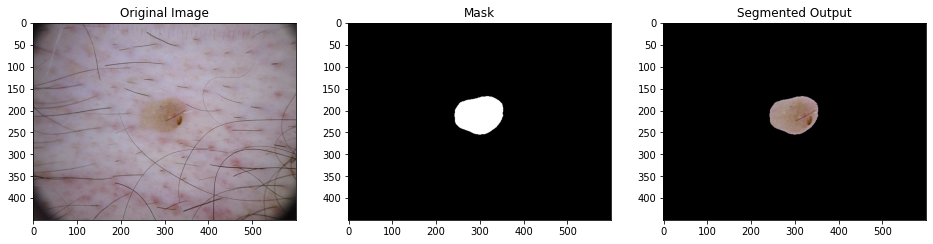

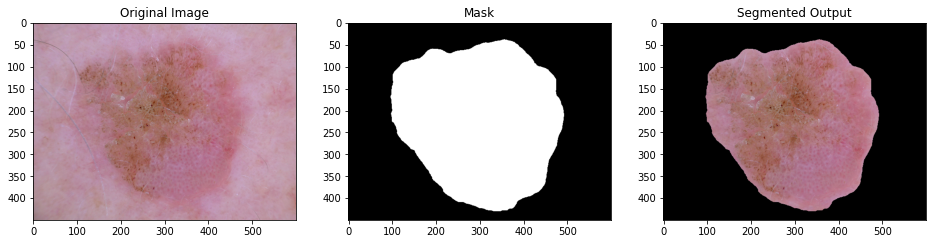

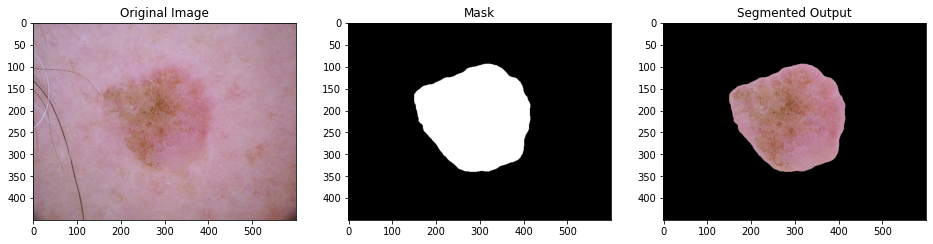

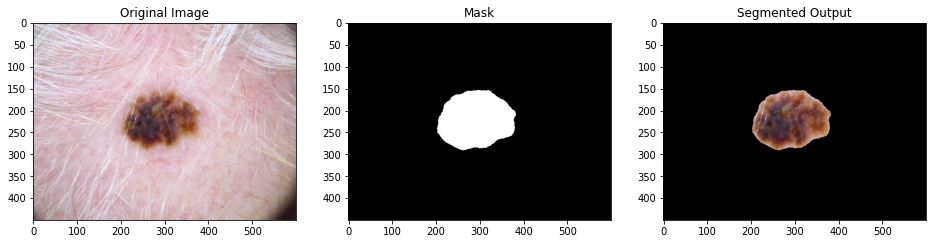

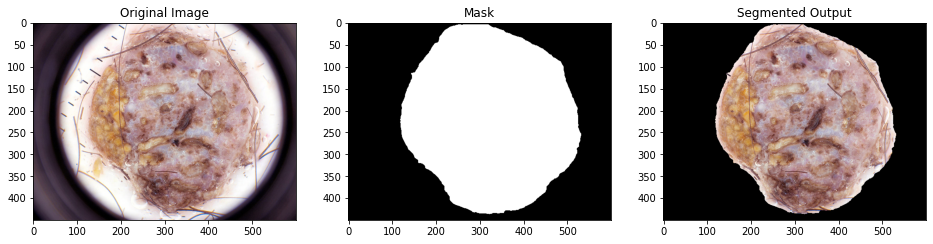

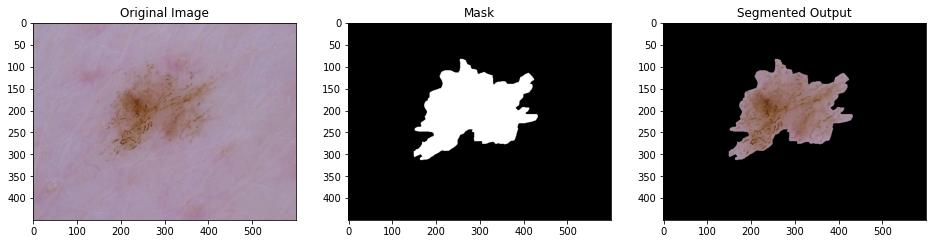

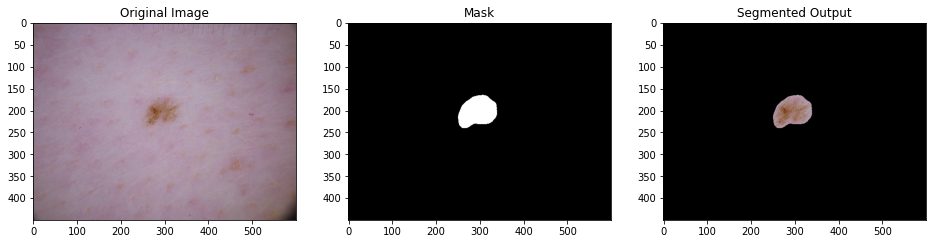

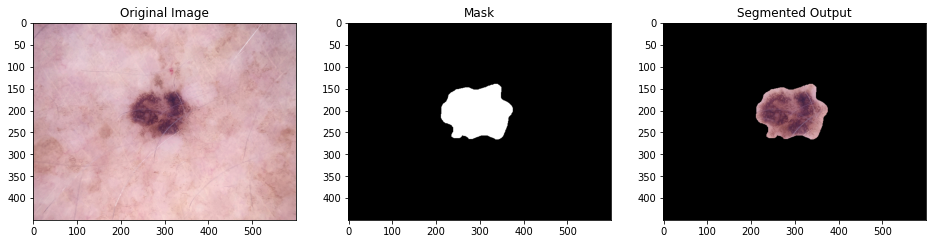

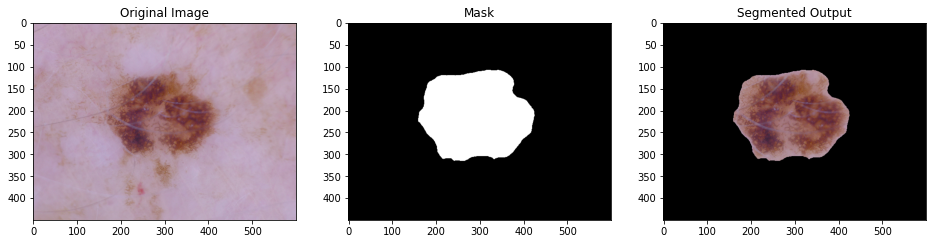

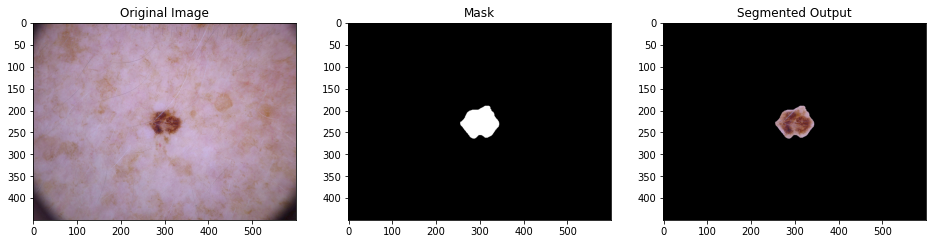

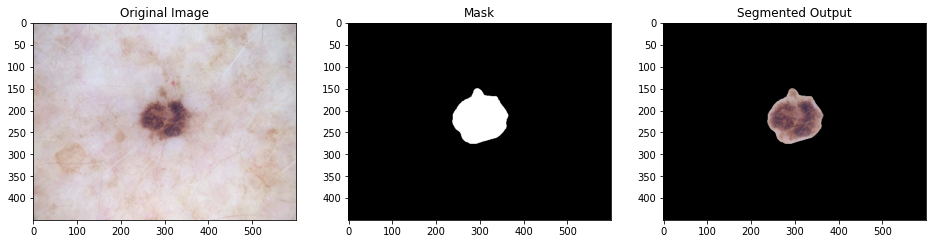

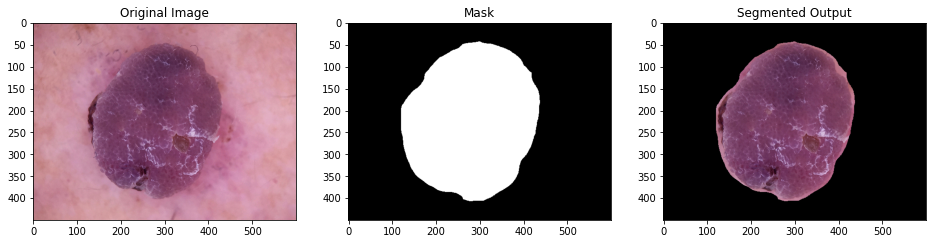

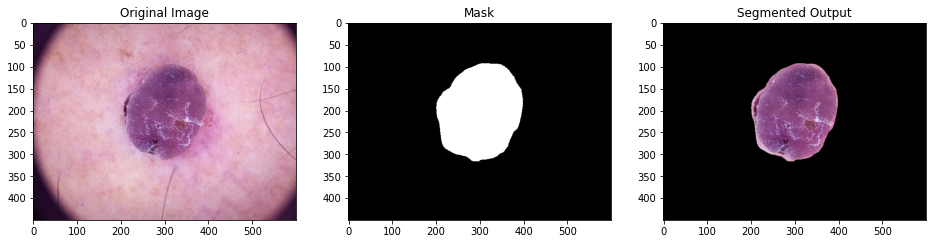

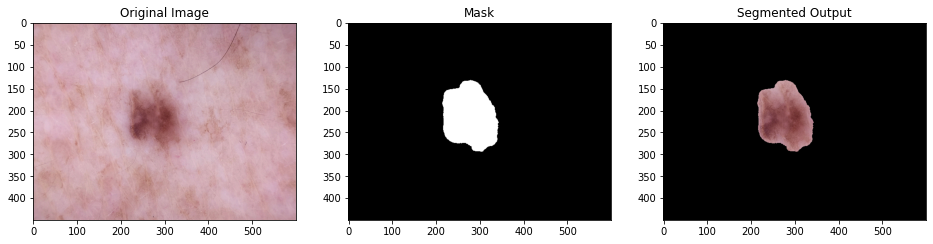

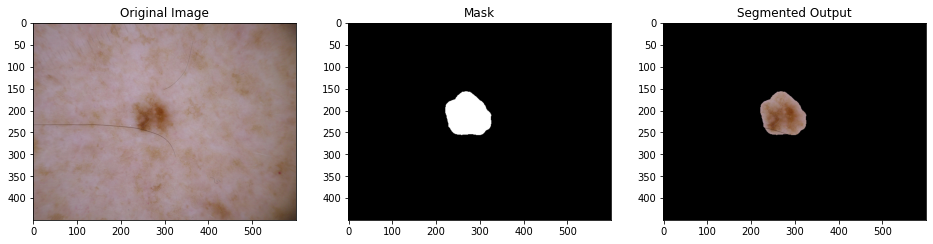

In [8]:
def applyMask(img, mask):
    res = cv2.bitwise_and(img, img, mask = mask)
    return res

def get_image_arr(i):
    img_index = skin_df[skin_df['image_id'] == i].index
    img_index = img_index[0]
    img_path = skin_df[skin_df['image_id'] == i]['image_path']
    img = img_path[img_index]
    img = np.array(Image.open(img))
    return img
    
def get_image_mask_arr(i):
    image_mask_id = f"{i}_segmentation"
    img_mask_index = skin_df[skin_df['image_mask_id'] == image_mask_id].index
    img_mask_index = img_mask_index[0]
    img_mask_path = skin_df[skin_df['image_mask_id'] == image_mask_id]['image_mask_path']
    img_mask = img_mask_path[img_mask_index]
    img_mask = np.array(Image.open(img_mask).convert('L'))//255
    return img_mask

for i in skin_df['image_id'][30:45]:
    img = get_image_arr(i)
    img_mask = get_image_mask_arr(i)    
    
    masked_img = applyMask(img, img_mask)
    plt.figure(figsize=(16,16))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(img_mask, plt.cm.binary_r)
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(masked_img)
    plt.title('Segmented Output')
    plt.show()

In [9]:
# os.removedirs(os.path.join(base_dir, "Data/reorganized_segmented_images/bkl"))

In [10]:
base_dir = os.getcwd() + "/"
Data_path = os.path.join(base_dir, "Data/")
os.mkdir(Data_path)
all_segmented_images = os.path.join(Data_path, "all_segmented_images/")
os.mkdir(all_segmented_images)
dest_dir = all_segmented_images

In [11]:
for i in skin_df['image_id']:
    img = get_image_arr(i)
    img_mask = get_image_mask_arr(i)    
    masked_img_array = applyMask(img, img_mask)
    masked_img = Image.fromarray(masked_img_array)
    masked_image_id = f"{i}_masked"
    masked_img.save(dest_dir + masked_image_id +'.png')

In [12]:
!zip -r all_segmented_images.zip "/kaggle/working/Data/all_segmented_images"

  adding: kaggle/working/Data/all_segmented_images/ (stored 0%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0032295_masked.png (deflated 2%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0028021_masked.png (deflated 1%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0025439_masked.png (deflated 0%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0027248_masked.png (deflated 1%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0029536_masked.png (deflated 1%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0025816_masked.png (deflated 12%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0034005_masked.png (deflated 0%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0030643_masked.png (deflated 0%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0028351_masked.png (deflated 1%)
  adding: kaggle/working/Data/all_segmented_images/ISIC_0026383_masked.png (deflated 1%)
  adding: kaggle/working/Data/all_segmented_i

In [13]:
segmented_image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/working/Data/all_segmented_images', '*.png'))}

In [14]:
skin_df['segmented_image_id'] = skin_df.agg(lambda x: f"{x['image_id']}_masked", axis=1)

#Define the image_mask_path and add as a new column
skin_df['segmented_image_path'] = skin_df['segmented_image_id'].map(segmented_image_path.get)

In [15]:
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,image_mask_id,image_mask_path,segmented_image_id,segmented_image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0027419_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0027419_masked,/kaggle/working/Data/all_segmented_images/ISIC...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025030_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025030_masked,/kaggle/working/Data/all_segmented_images/ISIC...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0026769_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0026769_masked,/kaggle/working/Data/all_segmented_images/ISIC...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025661_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025661_masked,/kaggle/working/Data/all_segmented_images/ISIC...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0031633_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0031633_masked,/kaggle/working/Data/all_segmented_images/ISIC...
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0027850_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0027850_masked,/kaggle/working/Data/all_segmented_images/ISIC...
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0029176_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0029176_masked,/kaggle/working/Data/all_segmented_images/ISIC...
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0029068_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0029068_masked,/kaggle/working/Data/all_segmented_images/ISIC...
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025837_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025837_masked,/kaggle/working/Data/all_segmented_images/ISIC...
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025209_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025209_masked,/kaggle/working/Data/all_segmented_images/ISIC...


In [16]:
# Dump all images into a folder and specify the path:

reorganized_segmented_images_path = os.path.join(Data_path, "reorganized_segmented_images")
os.mkdir(reorganized_segmented_images_path)

In [17]:
data_dir = all_segmented_images
# Path to destination directory where we want subfolders
dest_dir = reorganized_segmented_images_path

In [18]:
skin_df2 = skin_df
skin_df['dx'].value_counts()

label=skin_df2['dx'].unique().tolist()  #Extract labels into a list
label_images = []

In [19]:
# Copy images to new folders
for i in label:
    os.mkdir(dest_dir + "/" + str(i) + "/")
    sample = skin_df2[skin_df2['dx'] == i]['segmented_image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + id +".png"), (dest_dir + "/" + i + "/" +id +".png"))
    label_images=[] 

In [20]:
!zip -r reorganized_segmented_images.zip "/kaggle/working/Data/reorganized_segmented_images"

  adding: kaggle/working/Data/reorganized_segmented_images/ (stored 0%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ (stored 0%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0026456_masked.png (deflated 1%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0028406_masked.png (deflated 7%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0033031_masked.png (deflated 1%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0025596_masked.png (deflated 5%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0033092_masked.png (deflated 0%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0033458_masked.png (deflated 4%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0033817_masked.png (deflated 4%)
  adding: kaggle/working/Data/reorganized_segmented_images/vasc/ISIC_0028146_masked.png (deflated 1%)
  adding: kaggle/working/Data/reorg